# <center>Anomaly Detection</center>

Name: Aneesh Raskar
Reg no: 21BAI1516

In [1]:
# Import Libraries
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split as tts
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.layers import LSTM, GRU, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import load_model
import time
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
# from keras import regularizers
from keras.applications import VGG16

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
test_dir = '/kaggle/input/ucf-crime-dataset/Test'
train_dir = '/kaggle/input/ucf-crime-dataset/Train'

# Define the categories and labels required
categories_labels = {'Fighting': 0, 
                     'Shoplifting': 1, 
                     'Burglary': 2, 
                     'Arrest': 3, 
                     'Shooting': 4, 
                     'Robbery': 5, 
                     'Stealing': 6}

In [5]:
def load_data(base_dir, categories_labels):
    data = []
    # Go through each category
    for category, label in categories_labels.items():

        category_dir = os.path.join(base_dir, category)

        # Check if the directory exists
        if os.path.isdir(category_dir):
            for filename in tqdm(os.listdir(category_dir), desc=f"Loading {category}"):
                # Check if the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    image_path = os.path.join(category_dir, filename)
                    try:
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        image = cv2.resize(image, (50, 50))
                        image = image.reshape((1,) + image.shape + (1,))
                        data.append([image, label])
                    # Encountered error while loading image
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
    return data

In [6]:
# Load the training and test data
train_data = load_data(train_dir, categories_labels)
test_data = load_data(test_dir, categories_labels)

# Combine the training and test data
total_data = train_data + test_data

print(f"Loaded {len(total_data)} images.")

Loading Stealing: 100%|██████████| 1984/1984 [00:13<00:00, 146.26it/s]

Loaded 239180 images.


**Image Preprocessing**

In [8]:
images = []
labels = []

# Go through each image and its label in the total_data
for image, label in total_data:
    images.append(image)
    labels.append(label)

# Convert the lists into numpy arrays
images = np.array(images)
labels = np.array(labels)
print(images.shape)

# Reshape images for RNN
images_rnn = images.reshape(images.shape[0], -1, 1)  # Added third dimension for features

# Set a seed for reproducibility
seed = 42

# Split the data into training and testing sets for CNN
train_images_cnn, test_images_cnn, train_labels_cnn, test_labels_cnn = tts(images, labels, test_size=0.1, random_state=seed)

# Split the data into training and testing sets for RNN
train_images_rnn, test_images_rnn, train_labels_rnn, test_labels_rnn = tts(images_rnn, labels, test_size=0.1, random_state=seed)

# Convert labels to categorical for CNN
train_labels_cnn = np_utils.to_categorical(train_labels_cnn, len(categories_labels))
test_labels_cnn = np_utils.to_categorical(test_labels_cnn, len(categories_labels))

# Convert labels to categorical for RNN
train_labels_rnn = np_utils.to_categorical(train_labels_rnn, len(categories_labels))
test_labels_rnn = np_utils.to_categorical(test_labels_rnn, len(categories_labels))

# Remove the second dimension from your data
train_images_cnn = np.squeeze(train_images_cnn, axis=1)
test_images_cnn = np.squeeze(test_images_cnn, axis=1)

(239180, 1, 50, 50, 1)


**Model Designing**

In [23]:
# CNN Model Selection
# CNN Model1 (ReLU)- Rejected
# model_CNN = Sequential()
# model_CNN.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(50, 50, 1)))
# model_CNN.add(ReLU(alpha=0.1)) 
# model_CNN.add(MaxPooling2D((2, 2), padding='same')) 
# model_CNN.add(Dropout(0.25))
# model_CNN.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
# model_CNN.add(ReLU(alpha=0.1)) 
# model_CNN.add(MaxPooling2D((2, 2), padding='same')) 
# model_CNN.add(Dropout(0.25))
# model_CNN.add(Conv2D(128, (3, 3), padding='same')) 
# model_CNN.add(ReLU(alpha=0.1)) 
# model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
# model_CNN.add(Dropout(0.25))
# model_CNN.add(Conv2D(256, (3, 3), padding='same'))
# model_CNN.add(ReLU(alpha=0.1))
# model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
# model_CNN.add(Dropout(0.4))  
# model_CNN.add(Flatten()) 
# model_CNN.add(Dense(256)) 
# model_CNN.add(ReLU(alpha=0.1))            
# model_CNN.add(Dropout(0.5))
# -------------------------------------------------------------------------------------
# CNN Model2 (LeakyReLU)
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(50, 50, 1)))
model_CNN.add(LeakyReLU(alpha=0.1)) 
model_CNN.add(MaxPooling2D((2, 2), padding='same')) 
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_CNN.add(LeakyReLU(alpha=0.1)) 
model_CNN.add(MaxPooling2D((2, 2), padding='same')) 
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(128, (3, 3), padding='same')) 
model_CNN.add(LeakyReLU(alpha=0.1)) 
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(256, (3, 3), padding='same'))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
model_CNN.add(Dropout(0.4))  
model_CNN.add(Flatten()) 
model_CNN.add(Dense(256)) 
model_CNN.add(LeakyReLU(alpha=0.1))            
model_CNN.add(Dropout(0.5))
# -----------------------------------------------------------------------------------------------------

# RNN Model Selection
# GRU Model - Rejected
# model_RNN = Sequential()
# model_RNN.add(GRU(units = 8, return_sequences = True, input_shape = (2500, 1), activation='tanh'))
# model_RNN.add(GRU(units = 8, return_sequences = True))
# model_RNN.add(Dense(4, activation='tanh'))
# model_RNN.add(Dropout(0.2))
# model_RNN.add(Flatten())
# ----------------------------------------------------------------------------------------------------
# LSTM Model
model_RNN = Sequential()
model_RNN.add(LSTM(units = 8, return_sequences = True, input_shape = (2500, 1), activation='tanh'))
model_RNN.add(LSTM(units = 8, return_sequences = True))
model_RNN.add(Dense(4, activation='tanh'))
model_RNN.add(Dropout(0.2))
model_RNN.add(Flatten())
# ---------------------------------------------------------------------------------------------------
# Hybrid Model - Rejected
# model_RNN = Sequential()
# model_RNN.add(LSTM(units = 8, return_sequences = True, input_shape = (2500, 1), activation='tanh'))
# model_RNN.add(GRU(units = 8, return_sequences = True))
# model_RNN.add(Dense(4, activation='tanh'))
# model_RNN.add(Dropout(0.2))
# model_RNN.add(Flatten())

# Combine CNN and RNN model
nb_classes = 7
combined = concatenate([model_CNN.output, model_RNN.output], axis=-1)
output = Dense(nb_classes, activation='softmax')(combined)
model_final = Model(inputs=[model_CNN.input, model_RNN.input], outputs=output)

# Plot and compile the model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
mc = ModelCheckpoint('CNN_RNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [24]:
# Training the model
time1 = time.time()
history = model_final.fit([train_images_cnn, train_images_rnn], 
                          train_labels_rnn, 
                          batch_size=1000, 
                          epochs=10, 
                          validation_data=([test_images_cnn, test_images_rnn], test_labels_rnn), 
                          callbacks=[mc, csv_logger])
print (("Training time=", time.time()-time1))

# Save training history
np.save("CNN_RNN_history.npy", history.history)

Epoch 1/10


2024-03-25 15:54:53.109873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


216/216 [==============================] - ETA: 0s - loss: 1.4053 - accuracy: 0.5413
Epoch 1: val_loss improved from inf to 1.38510, saving model to CNN_RNN.h5
216/216 [==============================] - 91s 394ms/step - loss: 1.4053 - accuracy: 0.5413 - val_loss: 1.3851 - val_accuracy: 0.5715
Epoch 2/10
216/216 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.9103
Epoch 2: val_loss improved from 1.38510 to 0.58873, saving model to CNN_RNN.h5
216/216 [==============================] - 84s 389ms/step - loss: 0.3035 - accuracy: 0.9103 - val_loss: 0.5887 - val_accuracy: 0.8196
Epoch 3/10
216/216 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9734
Epoch 3: val_loss improved from 0.58873 to 0.22361, saving model to CNN_RNN.h5
216/216 [==============================] - 84s 389ms/step - loss: 0.0960 - accuracy: 0.9734 - val_loss: 0.2236 - val_accuracy: 0.9305
Epoch 4/10
216/216 [==============================] - ETA: 0s - loss: 0.0542 - accuracy:

In [25]:
from keras.models import load_model
fashion_model = load_model('./CNN_RNN.h5')
fashion_model.summary()

from contextlib import redirect_stdout
with open('./CNN_RNN'+".xls", 'w') as f:
    with redirect_stdout(f):
        fashion_model.summary()
# to get test accuracy and losses        
val_loss, val_accuracy=fashion_model.evaluate([test_images_cnn, test_images_rnn] ,test_labels_cnn) 
print(val_loss, val_accuracy)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_7_input (InputLayer)    [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 50, 50, 32)   320         ['conv2d_7_input[0][0]']         
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 50, 50, 32)   0           ['conv2d_7[0][0]']               
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 25, 25, 32)  0           ['leaky_re_lu_5[0][0]']          
                                                                                            

In [26]:
time2=time.time()
predict_prob=fashion_model.predict([test_images_cnn, test_images_rnn])
y_pred=np.argmax(predict_prob,axis=1)
print ('classification time:', time.time()-time2)

# print y_pred
y_true=np.argmax(test_labels_cnn, axis=1)

cm = confusion_matrix(y_true, y_pred)
print (cm)
print(classification_report(y_true, y_pred))

precision = precision_score(y_true, y_pred, average='weighted')
print('Precision: %f' % precision)
recall = recall_score(y_true, y_pred, average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 score: %f' % f1)

from sklearn.metrics import jaccard_score
print ('IoU:', jaccard_score(y_true, y_pred, average='micro'))


test_eval = fashion_model.evaluate([test_images_cnn, test_images_rnn], test_labels_cnn)

loss, accuracy = fashion_model.evaluate([train_images_cnn, train_images_rnn], train_labels_cnn)
print('loss_train: ', loss, 'accuracy_train: ', accuracy)
print('Test loss:', test_eval[0], 'Test accuracy:', test_eval[1])

748/748 [==============================] - 34s 44ms/step
classification time: 34.0868718624115
[[2585    0    5    1    1    0    1]
 [   1 3252    1    8    0    0    0]
 [   0    3 4643    3    1   11    0]
 [   3    4    2 2958    5    5    1]
 [   2    0    1   17 1492    1    1]
 [   0    1    3    1    0 4124    6]
 [   1    1    3    1    1   11 4757]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2593
           1       1.00      1.00      1.00      3262
           2       1.00      1.00      1.00      4661
           3       0.99      0.99      0.99      2978
           4       0.99      0.99      0.99      1514
           5       0.99      1.00      1.00      4135
           6       1.00      1.00      1.00      4775

    accuracy                           1.00     23918
   macro avg       1.00      0.99      0.99     23918
weighted avg       1.00      1.00      1.00     23918

Precision: 0.995531
Recall: 0.995526
F1 s

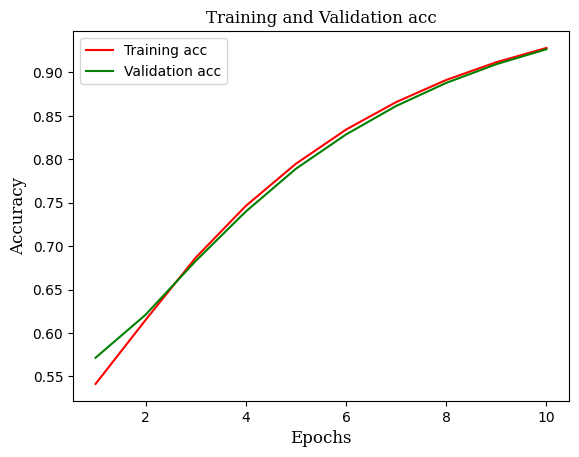

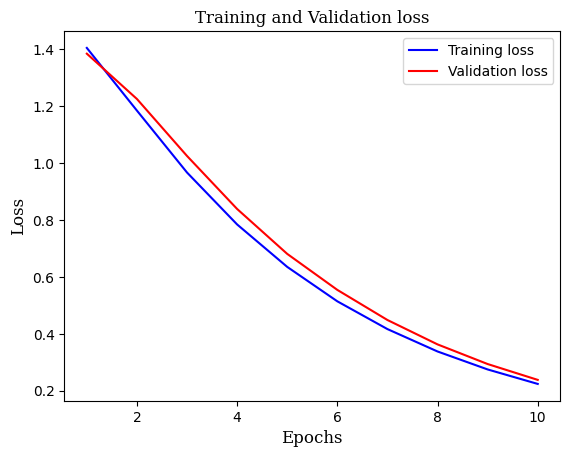

In [27]:
history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1, len(acc_values)+1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
loss_values=smooth_curve(loss_values)
val_loss_values=smooth_curve(val_loss_values)
acc_values=smooth_curve(acc_values)
val_acc_values=smooth_curve(val_acc_values)

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12}
        

plt.plot(epochs, acc_values, 'r-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.title('Training and Validation acc', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.legend()
plt.savefig("accuracy"+'CNN_RNN'+".png")
plt.show()

plt.plot(epochs, loss_values, 'b-', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation loss', fontdict=font)
plt.xlabel('Epochs',fontdict=font)
plt.ylabel('Loss',fontdict=font)
plt.legend()
plt.savefig("loss"+'CNN_RNN'+".png")
plt.show()


Confusion matrix, without normalization
[[2585    0    5    1    1    0    1]
 [   1 3252    1    8    0    0    0]
 [   0    3 4643    3    1   11    0]
 [   3    4    2 2958    5    5    1]
 [   2    0    1   17 1492    1    1]
 [   0    1    3    1    0 4124    6]
 [   1    1    3    1    1   11 4757]]


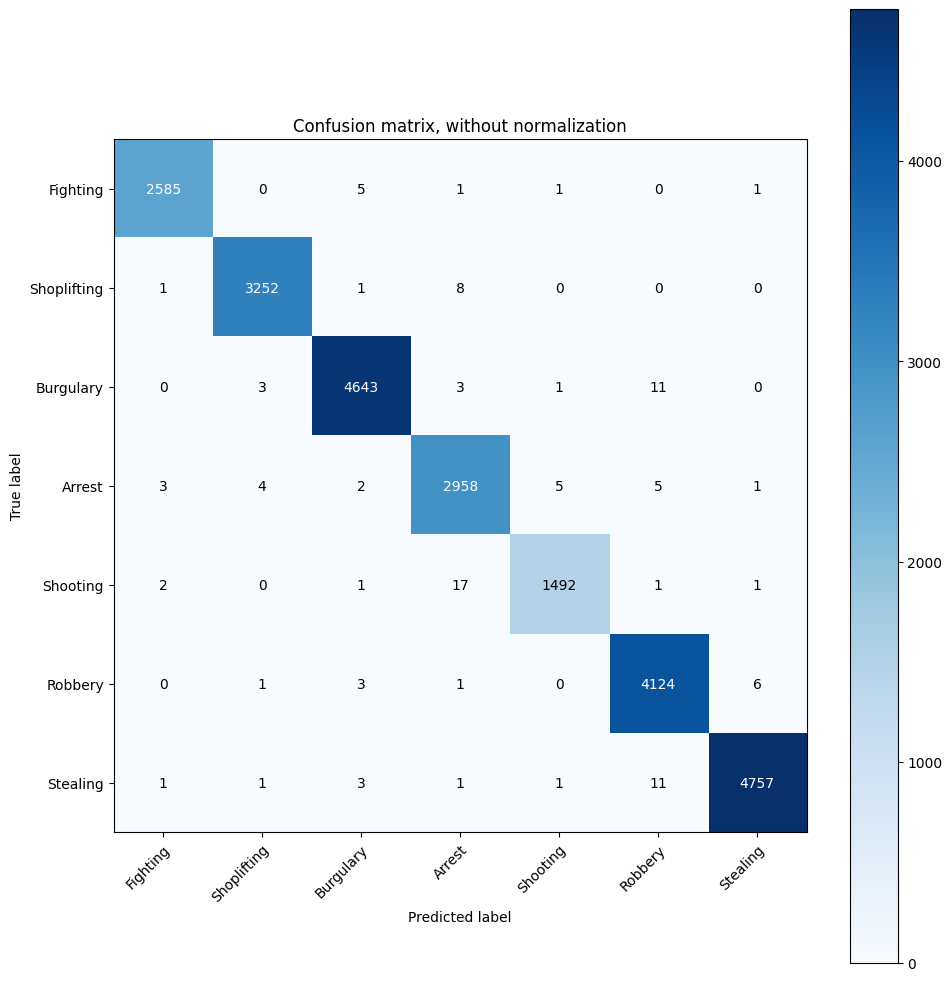

Normalized confusion matrix
[[9.97e-01 0.00e+00 1.93e-03 3.86e-04 3.86e-04 0.00e+00 3.86e-04]
 [3.07e-04 9.97e-01 3.07e-04 2.45e-03 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 6.44e-04 9.96e-01 6.44e-04 2.15e-04 2.36e-03 0.00e+00]
 [1.01e-03 1.34e-03 6.72e-04 9.93e-01 1.68e-03 1.68e-03 3.36e-04]
 [1.32e-03 0.00e+00 6.61e-04 1.12e-02 9.85e-01 6.61e-04 6.61e-04]
 [0.00e+00 2.42e-04 7.26e-04 2.42e-04 0.00e+00 9.97e-01 1.45e-03]
 [2.09e-04 2.09e-04 6.28e-04 2.09e-04 2.09e-04 2.30e-03 9.96e-01]]


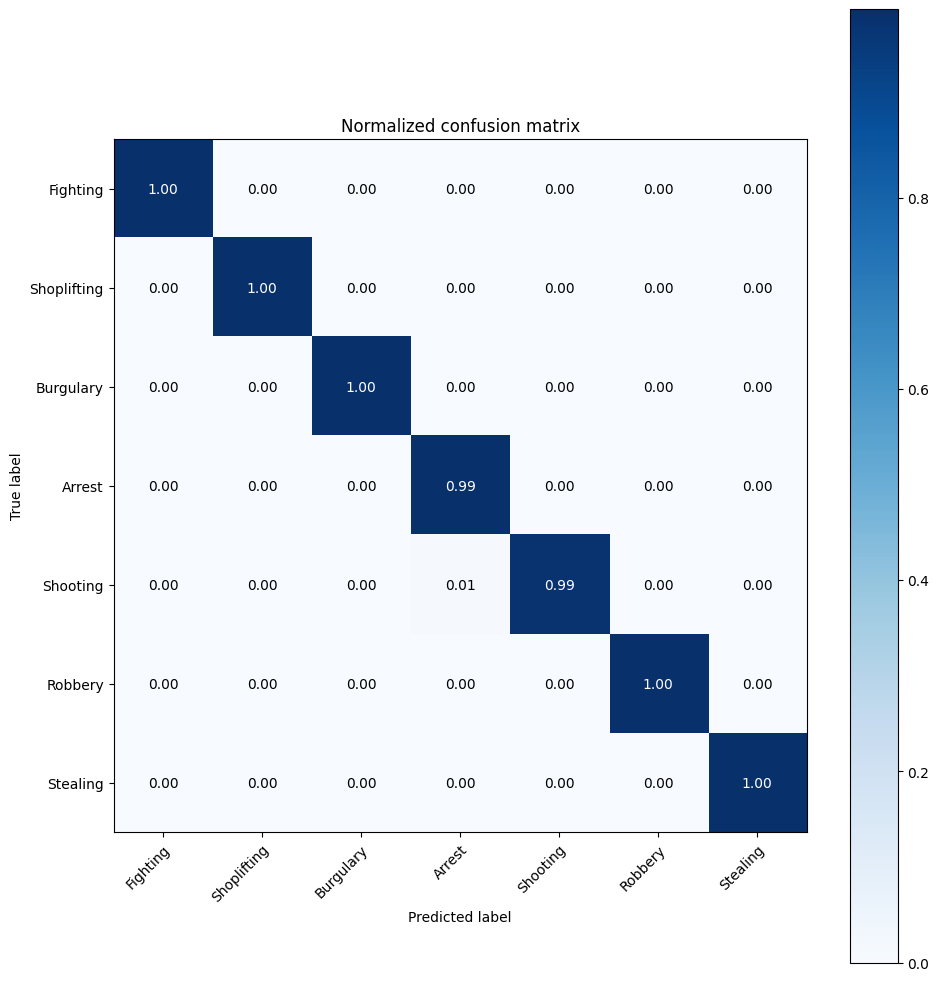

In [28]:
class_names = ['Fighting', 'Shoplifting', 'Burgulary', 'Arrest', 'Shooting', 'Robbery', 'Stealing']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 14}

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('confusion matrix1'+'CNN_RNN'+'.png')
plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion matrix2'+'CNN_RNN'+'.png')
plt.show()

In [29]:
categories_labels = {'Fighting': 0, 'Shoplifting': 1, 'Burglary': 2, 'Arrest': 3, 'Shooting': 4, 'Robbery': 5, 'Stealing': 6}
labels_categories = {v: k for k, v in categories_labels.items()}  # reverse dictionary for label lookup

# Load the trained model
model = load_model('/kaggle/working/CNN_RNN.h5')

def predict_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image
    image = cv2.resize(image, (50, 50))

    # Reshape the image to 4D array for CNN and RNN input
    image_cnn = image.reshape((1,) + image.shape + (1,))
    image_rnn = image.reshape((1,) + (-1, 1))

    # Use the model to predict the category of the image
    prediction = model.predict([image_cnn, image_rnn])

    # Find the category with the highest probability
    label = np.argmax(prediction)

    # Return the name of the category
    return labels_categories[label]

# Test the function
# Enter your image path
image_path = "/kaggle/input/input-feed-data/test2.png"
print(predict_image(image_path))


1/1 [==============================] - 1s 790ms/step
Robbery


In [33]:
# For.gif

categories_labels = {'Fighting': 0, 'Shoplifting': 1, 'Burglary': 2, 'Arrest': 3, 'Shooting': 4, 'Robbery': 5, 'Stealing': 6}
labels_categories = {v: k for k, v in categories_labels.items()}  # reverse dictionary for label lookup

# Load the trained model
model = load_model('/kaggle/working/CNN_RNN.h5')

def predict_image(image):
    # Resize the image
    image = cv2.resize(image, (50, 50))

    # Reshape the image to 4D
    image_cnn = image.reshape((1,) + image.shape + (1,))
    image_rnn = image.reshape((1,) + (-1, 1))

    prediction = model.predict([image_cnn, image_rnn])
    label = np.argmax(prediction)

    return labels_categories[label]

def extract_and_predict(gif_path):

    gif = Image.open(gif_path)

    # Extract frames from the gif
    frames = []
    try:
        while True:
            gif.seek(gif.tell() + 1)
            frames.append(np.array(gif.convert('L')))  # Convert image to grayscale
    except EOFError:
        pass

    # Predict the category of each frame and save it in a new directory
    new_dir = 'predicted_images'
    os.makedirs(new_dir, exist_ok=True)
    last_category = None  # variable to keep track of the last predicted category
    for i, frame in enumerate(frames):
        category = predict_image(frame)
        if category != last_category:  # only print the category if it's different from the last one
            print('Frame', i, 'Category:', category)
        last_category = category  # update the last predicted category
        cv2.imwrite(os.path.join(new_dir, f'{category}_{i}.png'), frame)

# Test the function
# Enter your gif path
gif_path = "/kaggle/input/input-feed-data/test2.gif"
extract_and_predict(gif_path)

1/1 [==============================] - 2s 2s/step
Frame 0 Category: Fighting
1/1 [==============================] - 0s 71ms/step
Frame 9 Category: Arrest
1/1 [==============================] - 0s 70ms/step
Frame 12 Category: Fighting
1/1 [==============================] - 0s 73ms/step
Frame 13 Category: Arrest
1/1 [==============================] - 0s 67ms/step
Frame 14 Category: Robbery
1/1 [==============================] - 0s 68ms/step
Frame 15 Category: Fighting
1/1 [==============================] - 0s 70ms/step
Frame 16 Category: Arrest
1/1 [==============================] - 0s 70ms/step
Frame 17 Category: Robbery
1/1 [==============================] - 0s 69ms/step
Frame 18 Category: Fighting
1/1 [==============================] - 0s 68ms/step
Frame 20 Category: Robbery
1/1 [==============================] - 0s 66ms/step
Frame 21 Category: Fighting
1/1 [==============================] - 0s 69ms/step
Frame 24 Category: Shoplifting
1/1 [==============================] - 0s 65ms/ste